In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [125]:
graph._node[0]

{'x': 22.733602246716966, 'y': 16.862884452848604, 'charger': False}

In [126]:
# Generating random graph
deep_reload(src)

seed = 12345
n = 100

x_scale = 100
y_scale = 100
min_link_length = 1e-6
max_link_length = 25

link_speeds = [35, 55, 90, 105]

weights = {
    'length': 40,
    'time': np.inf,
}

n_chargers = 10
n_targets = 5

rng = np.random.default_rng(seed)

x = rng.random(n) * x_scale
y = rng.random(n) * y_scale

nodes = []

for idx in range(n):

    nodes.append({
        'id': idx,
        'x': x[idx],
        'y': y[idx],
        'charger': rng.random() <= n_chargers / n
    })

links = []

for idx_s in range(n):
    for idx_t in range(n):

        source = nodes[idx_s]['id']
        target = nodes[idx_t]['id']

        link_length = src.utilities.pythagorean(
            nodes[idx_s]['x'],
            nodes[idx_s]['y'],
            nodes[idx_t]['x'],
            nodes[idx_t]['y'],
        )

        if (link_length < min_link_length) or (link_length > max_link_length):

            continue

        link_time = link_length / rng.choice(link_speeds)

        links.append({
            'source': source,
            'target': target,
            'length': link_length,
            'time': link_time,
        })

graph = src.graph.graph_from_nlg({'nodes': nodes, 'links': links})

chargers = {
    k: ['length'] for k, n in graph._node.items() if n['charger']
}

source_node = np.random.choice(list(graph.nodes))

target_nodes = np.random.choice(list(graph.nodes), size = n_targets, replace = False)

In [83]:
deep_reload(src)

source_node = np.random.choice(list(graph.nodes))

weights = {
    'length': 40,
    'time': np.inf,
}

path_weights = src.dijkstra.dijkstra_ev(graph, [source_node], weights = weights)

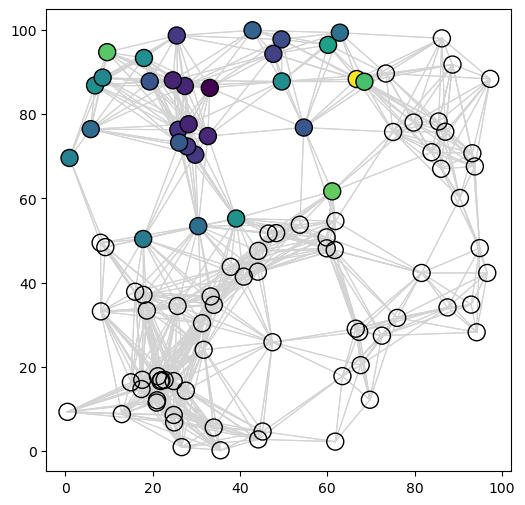

In [84]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (6, 6))

max_time = 0

for node in path_weights[0].values():

        max_time = max([max_time, node[1]])

for source, node in graph._node.items():

    try:    
        node['travel_time_norm'] = path_weights[0][source][1] / max_time

    except:
        node['travel_time_norm'] = np.nan

kwargs = {
    'node_field': 'travel_time_norm',
    'scatter': {
        's': 150,
        'ec': 'k',
        # 'c': 'k',
    },
    'plot': {
        'lw': .8,
        'zorder': 0,
        'color': 'lightgray',
    }
}

src.figures.graph(graph, ax = ax, **kwargs)

In [114]:
deep_reload(src)

# source_node = np.random.choice(list(graph.nodes))

weights = {
    'length': 40,
    'time': np.inf,
}

chargers = {n: ['length'] for n in np.random.choice(
    list(graph.nodes), size = 10, replace = False)}

path_weights = src.dijkstra.dijkstra_ev(
    graph, [source_node], chargers = chargers, weights = weights)

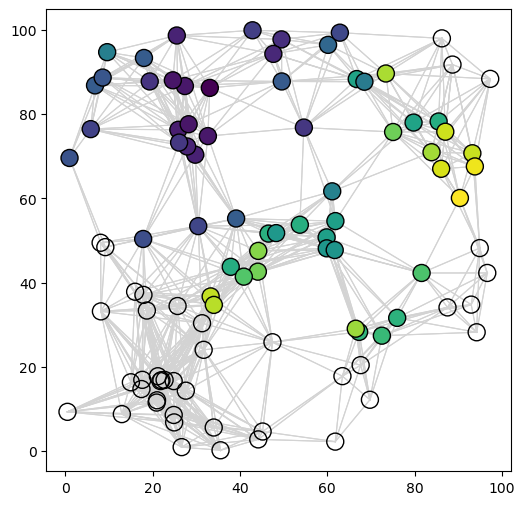

In [115]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (6, 6))

max_time = 0

for node in path_weights[0].values():

        max_time = max([max_time, node[1]])

for source, node in graph._node.items():

    try:    
        node['travel_time_norm'] = path_weights[0][source][1] / max_time

    except:
        node['travel_time_norm'] = np.nan

kwargs = {
    'node_field': 'travel_time_norm',
    'scatter': {
        's': 100,
        'ec': 'k',
        # 'c': 'k',
    },
    'plot': {
        'lw': .8,
        'zorder': 0,
        'color': 'lightgray',
    }
}

src.figures.graph(graph, ax = ax, **kwargs)

In [121]:
deep_reload(src)

# source_node = np.random.choice(list(graph.nodes))

weights = {
    'length': np.inf,
    'time': np.inf,
}

# chargers = {n: ['length'] for n in np.random.choice(
#     list(graph.nodes), size = 10, replace = False)}

targets = np.random.choice(list(graph.nodes), size = 5, replace = False)

path_weights = src.dijkstra.dijkstra_ev(
    graph, [source_node], targets = targets, weights = weights)

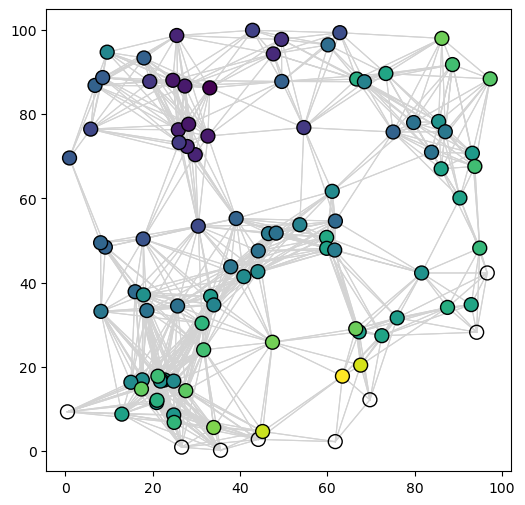

In [122]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (6, 6))

max_time = 0

for node in path_weights[0].values():

        max_time = max([max_time, node[1]])

for source, node in graph._node.items():

    try:    
        node['travel_time_norm'] = path_weights[0][source][1] / max_time

    except:
        node['travel_time_norm'] = np.nan

kwargs = {
    'node_field': 'travel_time_norm',
    'scatter': {
        's': 100,
        'ec': 'k',
        # 'c': 'k',
    },
    'plot': {
        'lw': .8,
        'zorder': 0,
        'color': 'lightgray',
    }
}

src.figures.graph(graph, ax = ax, **kwargs)